The intent of this notebook is to explore simple and exponential moving averages and see if they can provide any insight into when to buy or sell a stock

Install the TALIB library and import all necessary libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4532    0  4532    0     0  11580      0 --:--:-- --:--:-- --:--:-- 11590
100  517k  100  517k    0     0   408k      0  0:00:01  0:00:01 --:--:--  996k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4548    0  4548    0     0  16601      0 --:--:-- --:--:-- --:--:-- 16659
100  392k  100  392k    0     0   303k      0  0:00:01  0:00:01 --:--:--  422k


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as pl
import seaborn as sns
import pandas as pd
import datetime
import yfinance as yahoofin
from talib import SMA, EMA

Download training data, daily close prices for Microsoft from 2014 to 2023. Determine baseline performance (wait and hold Microsoft stock)

In [ ]:
#Data Entry
startDate = datetime.datetime(2014, 1, 1)
endDate = datetime.datetime(2023, 12, 30)
company = "MSFT"

data = yahoofin.Ticker(company).history(start = startDate, end=endDate)
data_close = data['Close']
baselinePerformance = np.log(data_close[-1]/data_close[200])
print(baselinePerformance)

2.3051314781146854


Let's explore a 50/200 short/long moving average

In [ ]:
SMA_50 = SMA(data_close, timeperiod=50)
SMA_200 = SMA(data_close, timeperiod=200)
results = pd.DataFrame({'Close': data_close, "SMA_50": SMA_50, "SMA_200":SMA_200})
results.tail(1000).plot(figsize=(12,10), color=['green','red','orange'])

<Axes: xlabel='Date'>

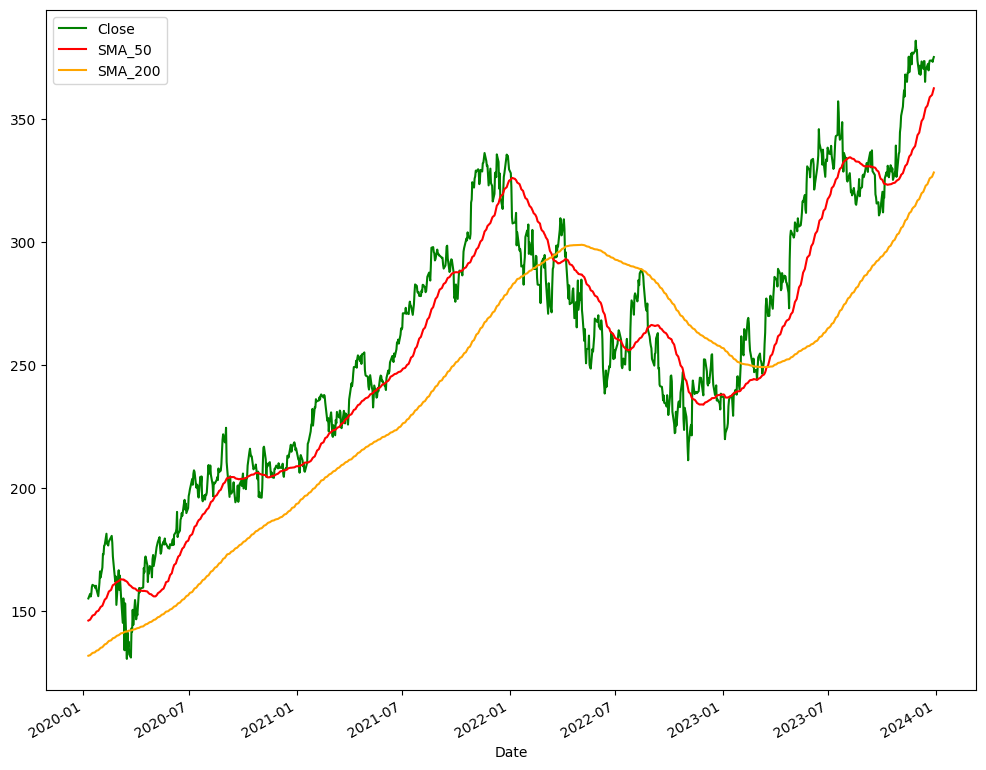

In [ ]:
results.tail(1000).plot(figsize=(12,10), color=['green','red','orange'])

Looking over the last 4 years, we can see a death cross in early 2022 and a golden cross in early 2023. Let's create some signals from the moving averages and see the performance of the strategy

In [ ]:
def SignalGeneration(prices):

  if 'SMA_Buy_Signal' not in prices.columns:
    prices['SMA_Buy_Signal'] = 0

  for i in range(200, len(prices)):
    if prices['SMA_50'][i] >= prices['SMA_200'][i]:
      prices['SMA_Buy_Signal'][i]=1

  if 'Daily_Returns' not in prices.columns:
    prices["Daily_Returns"] = (np.log(prices['Close']/ prices['Close'].shift(1)))

  if 'Strategy_Return' not in prices.columns:
    prices["SMA_Strategy_Returns"] = prices["Daily_Returns"]*prices["SMA_Buy_Signal"]


  return prices

In [ ]:
results = SignalGeneration(results)

In [ ]:
print(np.exp(results["SMA_Strategy_Returns"].sum()))
print(np.exp(baselinePerformance))

7.583833899932835
10.0254962991281


Well, looks like the strategy is not effective. The strategy results in only a 658% return over the decade, compared to the 1002% return for the buy and hold strategy. Let's see if EMA does any better.

In [ ]:
results["EMA_50"] = EMA(data_close, timeperiod=50)
results["EMA_200"] = EMA(data_close, timeperiod=200)

In [ ]:
def SignalGeneration_EMA(prices):

  if 'EMA_Buy_Signal' not in prices.columns:
    prices['EMA_Buy_Signal'] = 0

  for i in range(200, len(prices)):
    if prices['EMA_50'][i] >= prices['EMA_200'][i]:
      prices['EMA_Buy_Signal'][i]=1

  if 'Daily_Returns' not in prices.columns:
    prices["Daily_Returns"] = (np.log(prices['Close']/ prices['Close'].shift(1)))

  if 'EMA_Strategy_Return' not in prices.columns:
    prices["EMA_Strategy_Returns"] = prices["Daily_Returns"]*prices["EMA_Buy_Signal"]


  return prices

In [ ]:
results = SignalGeneration_EMA(results)

In [ ]:
print(np.exp(results["EMA_Strategy_Returns"].sum()))
print(np.exp(baselinePerformance))

8.994111867689684
10.0254962991281


Better than the SMA, but still worse than Buy and Hold. Let's see if there are better time periods to use

In [ ]:
# Brute Force approach.
# Will randomly select integer from 5 to 100 for the short timeperiod.
# The long timeperiod will randomly be selected from integers higher than short timeperiod and 200
#Start date of 200 is used for consistentcy among results


MC_results = []
MC_shortTP = []
MC_longTP = []
Daily_Returns = (np.log(data_close/ data_close.shift(1)))

for _ in range(0, 2500):
  short_TP = np.random.randint(5, 100)
  long_TP = np.random.randint(short_TP+1, 200)
  MC_shortTP.append(short_TP)
  MC_longTP.append(long_TP)
  long_TP_price = EMA(data_close, long_TP)
  short_TP_price = EMA(data_close, short_TP)
  Buy_Signal = np.zeros(len(data_close))

  for i in range(200, len(data_close)):
    if short_TP_price[i] >= long_TP_price[i]:
      Buy_Signal[i]=1

  Strategy_Returns = Buy_Signal * Daily_Returns
  MC_results.append(np.exp(Strategy_Returns.sum()))

print(max(MC_results))





116.38261850039922


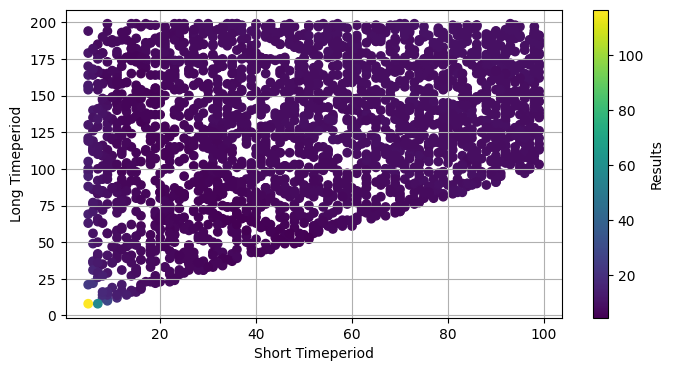

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(MC_shortTP, MC_longTP, c=MC_results, marker='o')
plt.grid(True)
plt.xlabel('Short Timeperiod')
plt.ylabel('Long Timeperiod')
plt.colorbar(label='Results')

In [ ]:
df = pd.DataFrame({"Results": MC_results, "Long Time":MC_longTP, "Short Time":MC_shortTP})
df2 = df.sort_values(by=["Results"], ascending=False)

In [ ]:
df2.head(25)

,Results,Long Time,Short Time
1009,116.382619,8,5
968,57.329489,8,7
967,28.258443,10,9
289,25.450134,12,8
243,23.267332,21,5
27,22.433202,11,9
719,22.179533,22,6
1390,18.489013,14,8
1580,17.280605,12,11
1928,17.231582,16,8


<Axes: xlabel='Date'>

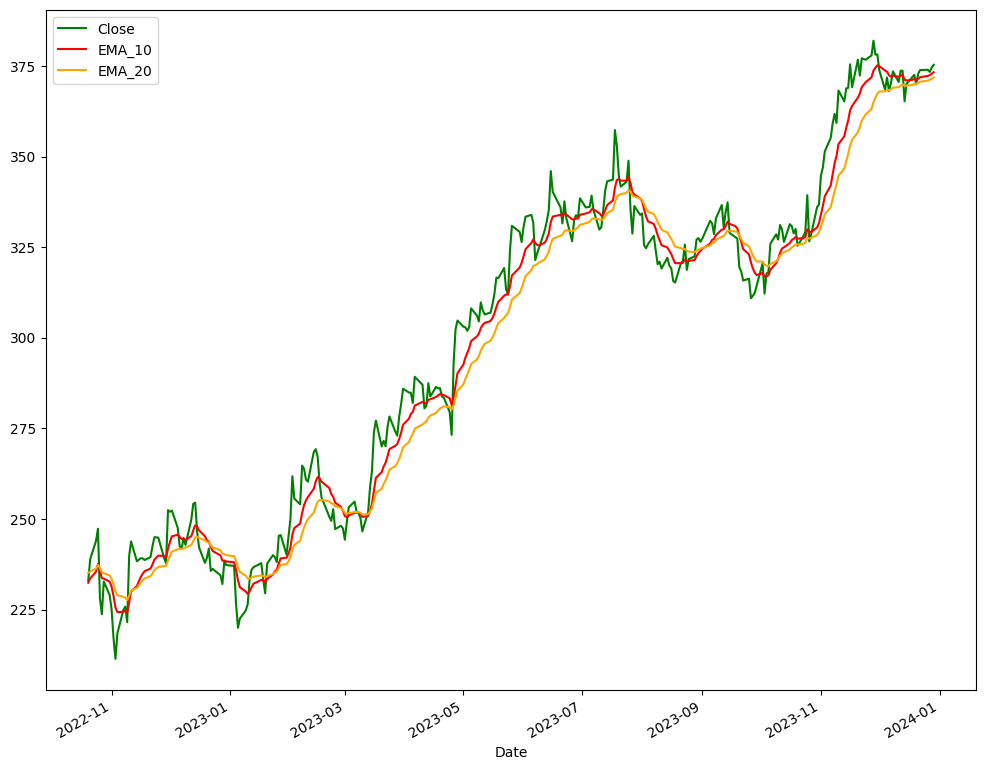

In [ ]:
EMA_20 = EMA(data_close, timeperiod=20)
EMA_10 = EMA(data_close, timeperiod=10)
results = pd.DataFrame({'Close': data_close, "EMA_10": EMA_10, "EMA_20":EMA_20})
results.tail(300).plot(figsize=(12,10), color=['green','red','orange'])

In [ ]:
!pip install quantstats

Check robustness of points (21 / 11 should not be significantly worse)

Check with January and February data

Check with Amazon and Johnson and Johnson